# Image classification: cats & dogs

In [1]:
# Handle imports up-front
import os
import glob
import random

# Silence info. messages from TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

# Import custom helper functions from utils.py
from utils import single_training_run
from utils import plot_single_training_run
from utils import hyperparameter_optimization_run
from utils import plot_hyperparameter_optimization_run

## 1. Data preparation

### 1.1. Load the data paths

In [2]:
# Set the path to the training data
training_data_path='../data/processed/train'

# Get a list of training dog and cat images
training_dogs=glob.glob(f'{training_data_path}/dog/dog.*')
training_cats=glob.glob(f'{training_data_path}/cat/cat.*')

### 1.2. Inspect

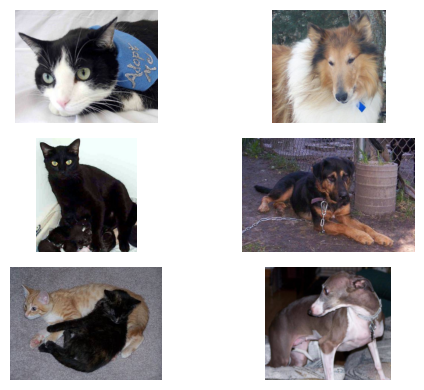

In [3]:
# Plot some of the cat and dog images
fig, axs = plt.subplots(3,2,figsize=(6, 4))

for cat, dog, row in zip(training_cats, training_dogs, axs):
    for animal, ax in zip([cat, dog], row):
        animal=image.load_img(animal)
        animal=image.img_to_array(animal)
        animal/=255.0
        ax.imshow(animal)
        ax.axis('off')

fig.tight_layout()

## 2. EDA

Let's take a deeper look at a few of our images to get a feel for how image data is structured.

### 2.1. Image data

In [4]:
# Load one of the dogs
dog=image.load_img(training_dogs[0])

# And convert it to an array - this is how TensorFlow will handel the data
dog=image.img_to_array(dog)

# Take a look at some properties of the object
print(f'Image data is: {type(dog)}')
print(f'Image data shape: {dog.shape}')

Image data is: <class 'numpy.ndarray'>
Image data shape: (500, 499, 3)


The data has shape of 375 x 499 x 3? The image is 375 x 499 pixels, that makes sense. But what is the 3? Let's plot the pixel values and you will see what is going on:

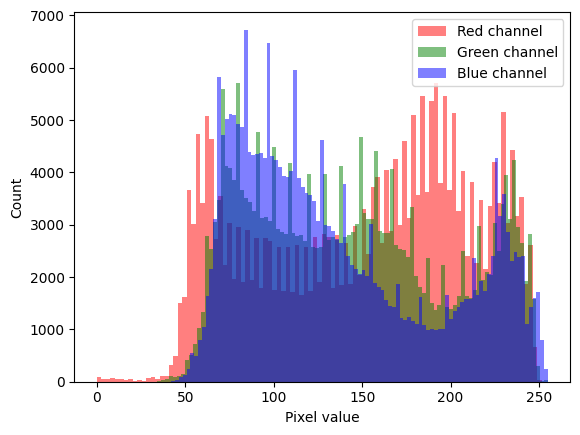

In [5]:
plt.hist(dog[:,:,0].flatten(), bins=100, color='red', alpha=0.5, label='Red channel')
plt.hist(dog[:,:,1].flatten(), bins=100, color='green', alpha=0.5, label='Green channel')
plt.hist(dog[:,:,2].flatten(), bins=100, color='blue', alpha=0.5, label='Blue channel')
plt.xlabel('Pixel value')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

There are a few interesting observations we can make here:

1. This array has 3 axes: 375 x 499 x 3. The first two are the dimensions of the image, the third is the three color channels: red, green and blue.
2. 375 x 499 x 3 is over a half million individual values - this one image is 10 time more data that any of the other datasets we have worked with so far!
3. The range of pixel values is from 0 to about 250 - in reality it is (0,255) for a total range of 256 possible values per pixel. This is defined by the JPEG image standard.

There are two things we can do with this information. First, we should scale the pixel values, this will improve the training of our neural network. We can do this directly in the model definition by adding a normalization layer. Second, we can make the images gray scale, which will decrease the input size and therefore computational burden by a factor of three. We can do this via the image dataset generator.

### 2.2. Image dimensions

Let's take a look at a random sample of images from the dataset and see what their dimensions are.

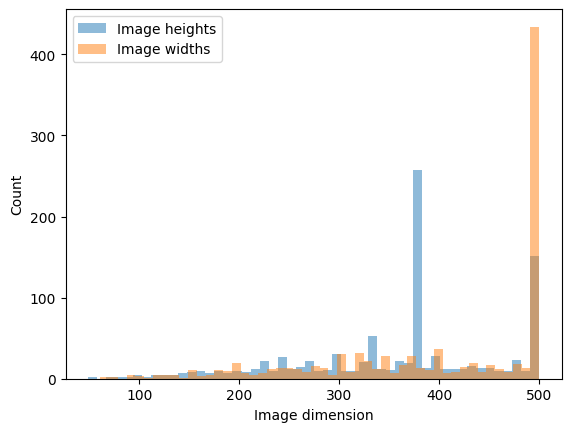

In [6]:
# Get a random sample of images, half cats and half dogs
sample_size=1000
sample=random.sample(training_dogs, sample_size//2)
sample+=random.sample(training_cats, sample_size//2)

# Collectors for data
heights=[]
widths=[]

# Loop on the sample images
for sample_image in sample:

    # Load the image and convert it to an array
    sample_image=image.load_img(sample_image)
    sample_image=image.img_to_array(sample_image)

    # Get the width and height and add to collections
    heights.append(sample_image.shape[0])
    widths.append(sample_image.shape[1])

# Plot results as a histogram
plt.hist(heights, bins=50, alpha=0.5, label='Image heights')
plt.hist(widths, bins=50, alpha=0.5, label='Image widths')
plt.xlabel('Image dimension')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

Based on the above plot, let's set our image dimension at 64 or 128 pixels. Smaller is better for training speed and memory use, but we don't want to go too small, then the model will have a hard time learning from the data. There is no hard and fast rule here. You could do an experiment testing several different image dimensions to see how small we could make the image and still get good performance.

In [7]:
image_width=64

### 2.3. Image aspect ratios

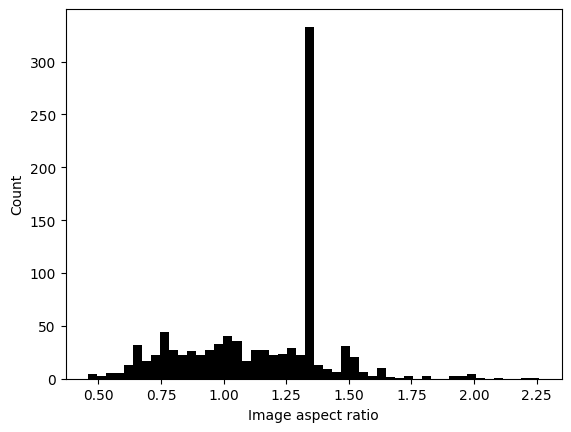

In [8]:
# Calculate the sample image aspect ratios
aspect_ratios=np.array(widths)/np.array(heights)

# Plot as histogram
plt.hist(aspect_ratios, bins=50, color='black')
plt.xlabel('Image aspect ratio')
plt.ylabel('Count')
plt.show()

The most common aspect ratio in the data set looks to be around 1.3 - which is the '4:3' aspect ratio that used to be the standard for computer monitors. Rather than using square input images, we can use this aspect ratio to better match the data.

In [9]:
# Set the target aspect ratio. We will use this later to
# calculate how tall the image should be based on the 
# requested image dim
aspect_ratio=4/3

## 2. Model

Now it's time to build and train the model. We will do this in a few steps, evaluating performance by looking at the training curves along the way:

1. Establish baseline performance with default settings
2. Optimize the batch size and learning rate
3. Optimize regularization with L1 and L2 penalties
4. Optimize input image size for speed and/or better performance
5. Optimize network architecture
6. Final model and evaluation

### 2.1. Baseline model training

In [ ]:
%%time

# Do a single training run with default settings
training_results=single_training_run(
    training_data_path,
    image_width=image_width
)

# Collect the results so we can plot all of the experiments together at the end
experiment_results={'Baseline model': training_results}

# Plot the results
plot_single_training_run(training_results).show()

print()

OK, not great. Does not seem like the model is learning at all. The training curves are jumping all over the place. This likely indicates that the learning rate is too large and/or the batch size is too small. Let's optimize those hyperparameters first.

### 2.2. Batch size and learning rate optimization

In [ ]:
%%time

# Define hyperparameters
hyperparameters={
    'batch_sizes': [128, 256],
    'learning_rates': [0.01, 0.0001, 0.000001],
    'image_widths': [64]
}

# Train the model with each set of hyperparameters
hyperparameter_optimization_results=hyperparameter_optimization_run(
    training_data_path,
    **hyperparameters
)

# Specify which hyperparameters to include in the plot labels
plot_labels=['batch_sizes', 'learning_rates']

# Plot the learning curves
plot_hyperparameter_optimization_run(
    hyperparameter_optimization_results,
    hyperparameters,
    plot_labels
).show()

print()

From the training curves, it looks like the best results are obtained with a batch size of 256 and a learning rate of 0.0001. That conclusion is somewhat subjective and based on how close the training and validation score curves are and their smoothness. Running more steps per epoch will slow the training down, but may help smooth the curves out somewhat.

### 2.3. Optimized model

Let's use the best batch size and learning rate settings and train the model for longer to see how it does.

In [ ]:
%%time

# Set some hyperparameters for the run
hyperparameters={'batch_size': 256, 'learning_rate': 0.0001, 'image_width': 64}

# Do a single training run
training_results=single_training_run(training_data_path, **hyperparameters)

# Collect the results so we can plot all of the experiments together at the end
experiment_results['Optimized model']=training_results

# Plot the results
plot_single_training_run(training_results).show()

print()

Looks better - but, we are clearly over fitting. Let's do a regularization experiment. We already built in the ability to pass L1 and L2 penalties to the dense layers, so here we go...

### 2.4. Regularization optimization

In [ ]:
%%time

# Define hyperparameters
hyperparameters={
    'batch_sizes': [256],
    'learning_rates': [0.0001],
    'l1_penalties': [0.01, 0.001, 0.0001],
    'l2_penalties': [0.01, 0.001, 0.0001],
    'image_widths': [64]
}

# Train the model with each combination of hyperparameters
hyperparameter_optimization_results=hyperparameter_optimization_run(
    training_data_path,
    **hyperparameters
)

# Specify which hyperparameters to include in the plot labels
plot_labels=['l1_penalties', 'l2_penalties']

# Plot the training curves
plot_hyperparameter_optimization_run(
    hyperparameter_optimization_results,
    hyperparameters,
    plot_labels
).show()

print()

The curves with and L1 penalty of 0.001 and an L2 penalty of 0.01 look best. This again is a little subjective; the goal if for the training and validation curves to be right on top of each other.

### 2.5. Optimized & regularized model

Now let's use the best values that we have determined for batch size, learning rate, L1 penalty and L2 penalty and train the model for longer to see how it does.

In [ ]:
%%time

# Set some hyperparameters for the run
hyperparameters={
    'l1_penalty': 0.001,
    'l2_penalty': 0.01,
    'batch_size': 256,
    'learning_rate': 0.0001,
    'image_width': 64
}

# Do a single training run
training_results=single_training_run(training_data_path, **hyperparameters)

# Collect the results so we can plot all of the experiments together at the end
experiment_results['Regularized model']=training_results

# Plot the results
plot_single_training_run(training_results).show()

print()

Good! Much better. Now let's revisit the image size. So far we have been using gray scale images of 64 by 48 pixels. We may be able to:

1. Use smaller images to create a more efficient model that maintains the same level of performance or
2. Increase performance by using larger images

### 2.6. Input image size optimization

Try a few different input image sizes and see how the model does with the hyperparameter settings we have chosen via optimization so far.

In [ ]:
%%time

# Define hyperparameters
hyperparameters={
    'batch_sizes': [256],
    'learning_rates': [0.0001],
    'l1_penalties': [0.001],
    'l2_penalties': [0.01],
    'image_widths': [32, 64, 128, 256]
}

# Train the model with each combination of hyperparameters
hyperparameter_optimization_results=hyperparameter_optimization_run(
    training_data_path,
    **hyperparameters
)

# Specify which hyperparameters to include in the plot labels
plot_labels=['image_widths']

# Plot the training curves
plot_hyperparameter_optimization_run(
    hyperparameter_optimization_results,
    hyperparameters,
    plot_labels
).show()

print()

In [ ]:
%%time

# Set some hyperparameters for the run
hyperparameters={
    'l1_penalty': 0.001,
    'l2_penalty': 0.01,
    'batch_size': 256,
    'learning_rate': 0.0001,
    'image_width': 256,
    'epochs': 500
}

# Do a single training run
training_results=single_training_run(training_data_path, **hyperparameters)

# Collect the results so we can plot all of the experiments together at the end
experiment_results['Input size optimized model']=training_results

# Plot the results
plot_single_training_run(training_results).show()

print()